In [1]:
import glob
import os
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import pandas as pd
data_dir = 'data_meg'
subj = "R2488"
dataqual = 'prepro' #or loc/exp
exp = 'exp' #or exp
dtype = "raw"
label_dir = 'data_log'
raw = mne.io.read_raw_fif('data_meg/R2488/prepro/R2488_exp.fif', preload=True)
save_dir = 'data_meg'
labels_df = pd.read_csv(f'{label_dir}/{subj}/label.csv')



Opening raw data file data_meg/R2488/prepro/R2488_exp.fif...


/var/folders/79/m99pb_8d67l3d79st4zhf4tc0000gn/T/ipykernel_30289/3710954101.py:15: RuntimeWarning: This filename (data_meg/R2488/prepro/R2488_exp.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif('data_meg/R2488/prepro/R2488_exp.fif', preload=True)


    Range : 0 ... 2779999 =      0.000 ...  2779.999 secs
Ready.
Opening raw data file /Users/dorisyu/meg_decoding/data_meg/R2488/prepro/R2488_exp-1.fif...
    Range : 2780000 ... 3309999 =   2780.000 ...  3309.999 secs
Ready.
Reading 0 ... 3309999  =      0.000 ...  3309.999 secs...


In [2]:
sfreq = raw.info['sfreq']
raw.filter(1, 40, method='iir')
downsample =10 

Filtering raw data in 2 contiguous segments
Setting up band-pass filter from 1 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 40.00 Hz: -6.02, -6.02 dB



In [3]:
events = mne.find_events(raw, stim_channel='STI 014', output='onset', shortest_event=1)
event_id = {
    'start': 160,
    'move': 161,
    'reveal_red': 162,
    'reveal_white': 163,
    'done': 164,
    'choice': 165,
    'timeout': 166
}

# Define trials to remove
trials_to_remove = []

4422 events found on stim channel STI 014
Event IDs: [160 161 162 163 164]


In [4]:
start_events = events[events[:, 2] == event_id['start']]
done_events = events[events[:, 2] == event_id['done']]
reveal_red_events = events[events[:, 2] == event_id['reveal_red']]
reveal_white_events = events[events[:, 2] == event_id['reveal_white']]
sfreq = raw.info['sfreq']  # Sampling frequency
# Initialize a list to store trial information
trial_info = []
trial_t = 26
start_idx = 0
previous_start_sample = None
processed_starts = set() 
# Iterate through each start event to create trial information
for idx, start_event in enumerate(start_events):
    start_sample = start_event[0]
    done_sample = start_sample + int(trial_t * sfreq)
    # Check if the current start is at least 20 seconds after the previous start
    if (previous_start_sample is None or (start_sample - previous_start_sample) / sfreq >= 20) and start_sample not in processed_starts:
        # Proceed with processing this start event
        previous_start_sample = start_sample
        processed_starts.add(start_sample)  # Add to the set of processed starts
        
        
    # Calculate tmin and tmax for the epoch
        tmin = -0.2  # 0.2 s before 'start'
        tmax = trial_t   # Duration from 'start' to 25 s after start 

        reveal_red_within_trial = reveal_red_events[(reveal_red_events[:, 0] > start_sample) & 
                                                    (reveal_red_events[:, 0] < done_sample)]
        reveal_white_within_trial = reveal_white_events[(reveal_white_events[:, 0] > start_sample) & 
                                                        (reveal_white_events[:, 0] < done_sample)]
        
            # Store trial information, including whether 'reveal_red' and 'reveal_white' occurred
        trial_info.append({
            'event_sample': start_sample,
            'trial_index': start_idx,
            'duration': tmax,
            'tmin': tmin,
            'tmax': tmax,
            'start_times': start_sample / sfreq,
            'reveal_red': len(reveal_red_within_trial) > 0,  # Boolean flag indicating if 'reveal_red' occurred
            'reveal_red_times': (reveal_red_within_trial[:, 0] - start_sample) / sfreq if len(reveal_red_within_trial) > 0 else [],
            'reveal_white': len(reveal_white_within_trial) > 0,  # Boolean flag indicating if 'reveal_white' occurred
            'reveal_white_times': (reveal_white_within_trial[:, 0] - start_sample) / sfreq if len(reveal_white_within_trial) > 0 else [],
            'reveal_times': sorted(
                ((reveal_red_within_trial[:, 0] - start_sample) / sfreq).tolist() +
                ((reveal_white_within_trial[:, 0] - start_sample) / sfreq).tolist()
            ) 
        })  
        start_idx += 1

In [5]:
new_events = np.array([[info['event_sample'], 0, event_id['start']] for info in trial_info])
tmin = -0.2  
# Initialize lists to store individual epochs data and trial information
epochs_data_list = []
trial_info_valid = []

In [6]:
# Iterate over new_events and create epochs, skipping the unwanted trials
for idx, event in enumerate(new_events):
    start_sample = event[0]
    event_id_code = event[2]
    event_time = start_sample / sfreq
    total_duration = raw.times[-1]
    print(f"Tmax is {tmax}")
    # Create the epoch
    epochs = mne.Epochs(
        raw, [event], event_id={f'event_{event_id_code}': event_id_code},
        tmin=tmin, tmax=tmax, preload=True,
        reject_by_annotation=False, reject=None, verbose=True
    )

    # Append valid epochs to the list
    if len(epochs) > 0:
        epochs_data_list.append(epochs.get_data()[:, :, ::downsample])
        trial_info_valid.append(trial_info[idx])
    else:
        print(f"Epoch {idx} was dropped.")
        print(f"Drop log for Epoch {idx}: {epochs.drop_log}")


Tmax is 25
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 25201 original time points ...
0 bad epochs dropped
Tmax is 25
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 25201 original time points ...
0 bad epochs dropped
Tmax is 25
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 25201 original time points ...
0 bad epochs dropped
Tmax is 25
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preload

## Decoding

In [7]:
from mne.decoding import SlidingEstimator, cross_val_multiscore, Vectorizer
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from matplotlib import pyplot as plt
label_encoder = LabelEncoder()
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score


In [8]:
# Step 1: Get the valid trial indices
valid_trial_indices = {info['trial_index'] for info in trial_info_valid}

# Step 2: Filter labels_df to only include valid trial indices
labels_df_filtered = labels_df[labels_df['trial_index'].isin(valid_trial_indices)]

# Create a mapping from trial_index to label using the filtered labels_df
label_dict = dict(zip(labels_df_filtered['trial_index'], labels_df_filtered['trial.rule']))

# Step 3: Extract labels for the valid trials in trial_info_valid
y_labels = []
for info in trial_info_valid:
    idx = info['trial_index']
    if idx in label_dict:
        y_labels.append(label_dict[idx])

# Convert labels to integers using label encoder
y = label_encoder.fit_transform(y_labels)

# Print the number of labels and valid trials after matching
n_labels = len(y_labels)
n_trials = len(trial_info_valid)
print(f"Number of labels after matching: {n_labels}")
print(f"Number of valid trials after matching: {n_trials}")


Number of labels after matching: 120
Number of valid trials after matching: 120


# Cross-validation

In [17]:
X = np.array([md.data for md in epochs_data_list])  # Shape: (n_epochs, n_channels, n_times)
X = X.squeeze(axis=1)
# Extract labels
y = label_encoder.fit_transform(y_labels)  # Convert labels to integers


In [20]:

def evaluate_model(y_true, y_pred, class_names):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Print confusion matrix
    print("Confusion Matrix:")
    print(cm)
    
    # Calculate weighted F1 score
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"Weighted F1 Score: {f1:.2f}")

    # Print classification report for more detailed metrics
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))


In [11]:
n_time_points = X.shape[2]
n_classes = len(np.unique(y))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def train_time_decoder(X, y, cv):
        # Train the time decoder on the entire dataset
    x_len = len(X)
    x_first = X[:x_len//2]
    y_first = y[:x_len//2]
    x_later = X[-x_len//2:]
    y_later = y[-x_len//2:]
    clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    time_decoding = SlidingEstimator(clf, n_jobs=5, scoring='accuracy')
    
    # Perform cross-validation for the first 50 trials
    scores_first = cross_val_multiscore(time_decoding, x_first, y_first, cv=cv, n_jobs=5)
    mean_scores_first = np.mean(scores_first, axis=0)
    
    # Perform cross-validation for the later 50 trials
    scores_later = cross_val_multiscore(time_decoding, x_later, y_later, cv=cv, n_jobs=5)
    mean_scores_later = np.mean(scores_later, axis=0)
    return mean_scores_first, mean_scores_later


# Function to perform time decoding and plot results for two sets of trials
def plot_time_decoding(mean_scores_first, mean_scores_later,title):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot the first 50 trials
    axes[0].plot(np.arange(n_time_points), mean_scores_first, label='First 50 Trials Accuracy')
    axes[0].axvline(x=2500, color='m', linestyle='--', label='Done')
    axes[0].axhline(1/n_classes, color='k', linestyle='--', label='chance')
    axes[0].set_xlabel('Time Points')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('First 50 Trials')
    axes[0].legend(loc='upper right')
    axes[0].set_ylim(0, 0.7)

    # Plot the later 50 trials
    axes[1].plot(np.arange(n_time_points), mean_scores_later, label='Later 50 Trials Accuracy', linestyle='--')
    axes[1].axvline(x=2500, color='m', linestyle='--', label='Done')
    axes[1].axhline(1/n_classes, color='k', linestyle='--', label='chance')
    axes[1].set_xlabel('Time Points')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Later 50 Trials')
    axes[1].legend(loc='upper right')
    axes[1].set_ylim(0, 0.7)


    plt.suptitle(title)
    plt.tight_layout()
    plt.show()



In [21]:
from scipy.ndimage import gaussian_filter1d
mean_scores_first, mean_scores_later = train_time_decoder(X, y, cv)
# Function to smooth the scores using a Gaussian filter
def smooth_scores(scores, sigma=2):
    return gaussian_filter1d(scores, sigma=sigma)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
  0%|          | Fitting SlidingEstimator : 0/2521 [00:00<?,       ?it/s]
  0%|          | Fitting SlidingEstimator : 6/2521 [00:00<01:58,   21.15it/s]
  0%|          | Fitting SlidingEstimator : 11/2521 [00:00<01:40,   25.03it/s][A
  1%|          | Fitting SlidingEstimator : 13/2521 [00:00<01:31,   27.37it/s][A
  1%|          | Fitting SlidingEstimator : 16/2521 [00:00<01:26,   29.01it/s]
  1%|          | Fitting SlidingEstimator : 18/2521 [00:00<01:27,   28.51it/s]
  1%|          | Fitting SlidingEstimator : 19/2521 [00:00<01:29,   28.02it/s]
  1%|          | Fitting SlidingEstimator : 21/2521 [00:00<01:24,   29.71it/s]
  1%|          | Fitting SlidingEstimator : 16/2521 [00:00<01:34,   26.45it/s]
  1%|          | Fitting SlidingEstimator : 23/2521 [00:00<01:24,   29.55it/s]
  1%|          | Fitting SlidingEstimator : 24/2521 [00:00<01:25,   29.33it/s]
  1%|          | Fitting SlidingEstimator : 25/2521 [00:00

/s]
 44%|████▍     | Fitting SlidingEstimator : 1121/2521 [00:38<00:45,   30.66it/s]


 47%|████▋     | Fitting SlidingEstimator : 1182/2521 [00:40<00:42,   31.66it/s]

 43%|████▎     | Fitting SlidingEstimator : 1072/2521 [00:37<00:48,   29.98it/s]
 45%|████▍     | Fitting SlidingEstimator : 1124/2521 [00:38<00:42,   32.66it/s]



 36%|███▋      | Fitting SlidingEstimator : 917/2521 [00:32<00:57,   27.79it/s]

 43%|████▎     | Fitting SlidingEstimator : 1073/2521 [00:37<00:48,   29.90it/s]


 40%|████      | Fitting SlidingEstimator : 1011/2521 [00:35<00:49,   30.34it/s]



 47%|████▋     | Fitting SlidingEstimator : 1183/2521 [00:40<00:44,   30.31it/s][A

 43%|████▎     | Fitting SlidingEstimator : 1074/2521 [00:37<00:48,   29.72it/s]
 45%|████▍     | Fitting SlidingEstimator : 1125/2521 [00:38<00:44,   31.20it/s]


 47%|████▋     | Fitting SlidingEstimator : 1186/2521 [00:40<00:41,   32.22it/s]

 43%|████▎     | Fitting SlidingEstimator : 1075/2521 [00:37<00:48,   29.67it/s]
 45%|██

(0.0, 0.7)

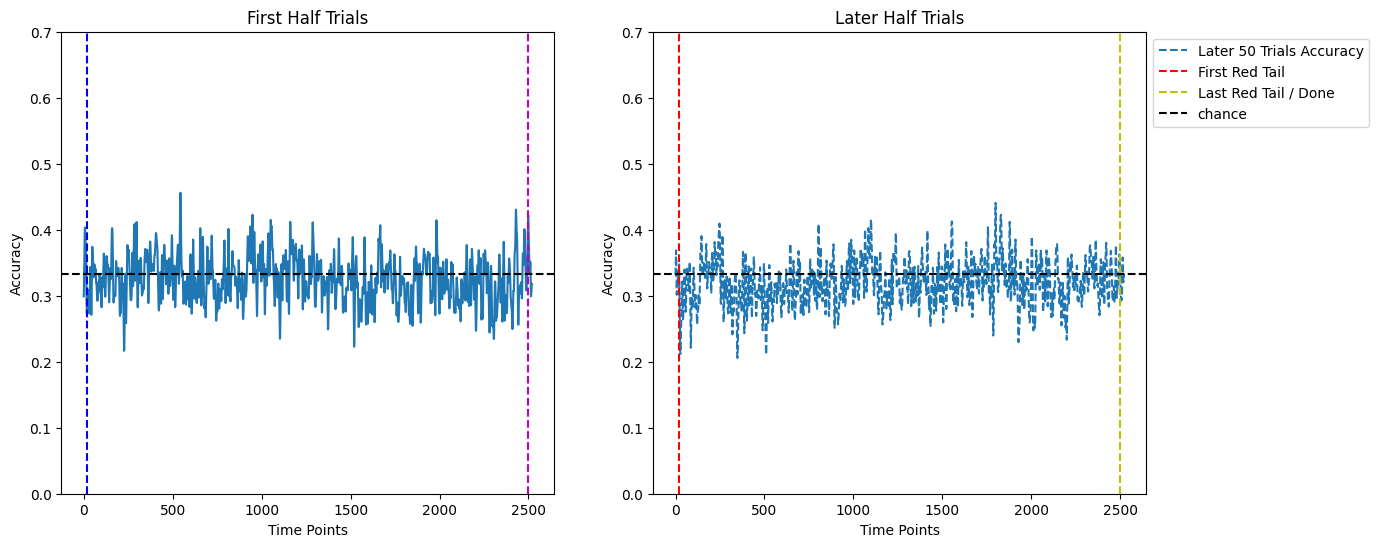

In [25]:
n_time_points = mean_scores_first.shape[0]
# Plot the first 50 trials
smoothed_scores_first = smooth_scores(mean_scores_first)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].plot(np.arange(n_time_points), smoothed_scores_first, label='First 50 Trials Accuracy')
axes[0].axvline(x=20, color='b', linestyle='--', label='Start')
axes[0].axvline(x=2500, color='m', linestyle='--', label='Done')
axes[0].axhline(1/n_classes, color='k', linestyle='--', label='chance')
axes[0].set_xlabel('Time Points')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('First Half Trials')
axes[0].set_ylim(0, 0.7)

# Plot the later 50 trials
smoothed_scores_later = smooth_scores(mean_scores_later)
axes[1].plot(np.arange(n_time_points), smoothed_scores_later, label='Later 50 Trials Accuracy', linestyle='--')
# axes[1].axvline(x=50, color='b', linestyle='--', label='Start')
axes[1].axvline(x=20, color='r', linestyle='--', label='First Red Tail')

axes[1].axvline(x=2500, color='y', linestyle='--', label='Last Red Tail / Done')
axes[1].axhline(1/n_classes, color='k', linestyle='--', label='chance')
axes[1].set_xlabel('Time Points')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Later Half Trials')
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[1].set_ylim(0, 0.7)

